참고 : [keras example image classification with version transformer](https://keras.io/examples/vision/image_classification_with_vision_transformer/)

이해를 위한 영상자료

https://youtu.be/i2_zJ0ANrw0 (keras code 리뷰)

https://youtu.be/91Qipj5NMnk (엔자이너 TV-vision transformer)

https://youtu.be/bgsYOGhpxDc (transformer / self-attention에 대한 이해)

https://youtu.be/QcCJJOLCeJQ (vision transformer 발전의 의의)

아래의 해석엔 의역, 오역이 있을 수 있습니다. 

# Image classification with Vision Transformer

**Author:** [Khalid Salama](https://www.linkedin.com/in/khalid-salama-24403144/)<br>
**Date created:** 2021/01/18<br>
**Last modified:** 2021/01/18<br>
**Description:** Implementing the Vision Transformer (ViT) model for image classification.

## Introduction

이 예제에서는 이미지 분류를 위해 Alexey Dosovitskiy et al.의 [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929)를 구현하고, CIFAR-100 데이터셋에서 이를 시행합니다. ViT model은 이미지 패치 시퀀스에 Convolution layer를 사용하지 않고 self-attention으로 Transformer architecture를 적용합니다.

이 예제는 Tensorflow 버전 2.4 이상의 버전([TensorFlow Addons](https://www.tensorflow.org/addons/overview))을 요구합니다. 아래의 코드로 설치가 가능합니다.
```python
pip install -U tensorflow-addons
```

## Setup

In [ ]:
pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 31.3 MB/s 


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

## Prepare the data

In [ ]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


169001437/169001437 [==============================] - 14s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Configure the hyperparameters

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # 입력이미지의 크기를 이 사이즈로 조정합니다.
patch_size = 6  # 입력이미지에서 추출할 패치의 크기
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # transformer의 레이어 사이즈
transformer_layers = 8
mlp_head_units = [2048, 1024]  # 최종 transformer에서의 dense layer사이즈


## Use data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# normalization을 위해 train data의 평균과 분산을 계산해줍니다.
data_augmentation.layers[0].adapt(x_train)


## Implement multilayer perceptron (MLP)

In [ ]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement patch creation as a layer

In [ ]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Let's display patches for a sample image

이미지를 resize 후 patch사이즈로 쪼개기 

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


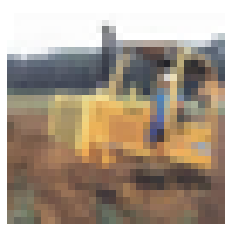

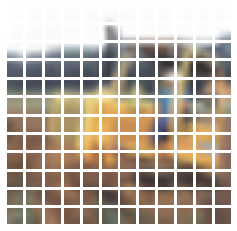

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer

 `PatchEncoder` layer 는 레이어를 선형으로 'projection_dim'사이즈로 transform합니다. 그리고 학습가능한 위치의 벡터에 투영합니다. 

In [ ]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


## Build the ViT model

ViT model은 여러개의 Transformer block으로 구성되며 ,  self-attention mechanism으로 적용되는 'layers.MultiHeadAttention' 레이어를 사용하는 patch sequence에 적용됩니다. Transformer block은 '[batch_size, num_patches, projection_dim]'으로 처리되며, 최종 class의 output을 출력하기 위해 softmax처리됩니다. 

[paper](https://arxiv.org/abs/2010.11929) 에 기술한 것과 다르게, 제공할 인코딩된 패치 시퀀스에 이미지표현으로 학습가능한 임베딩을 추가합니다. 최종 Transformer의 모든 출력은 'layer.Flatten()'으로 모양을 변경하고 classifier head 에 input으로 사용됩니다. 'layers.GlobalAveragePooling1D' 레이어는
Transformer 블록의 출력을 집계하는 뿐아니라 patch와 projection dimension수가 클 때 사용할 수도 있습니다.

In [ ]:

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Compile, train, and evaluate the mode

In [ ]:

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


Epoch 1/100
176/176 [==============================] - 99s 497ms/step - loss: 4.4841 - accuracy: 0.0436 - top-5-accuracy: 0.1579 - val_loss: 3.9504 - val_accuracy: 0.1096 - val_top-5-accuracy: 0.3226
Epoch 2/100
176/176 [==============================] - 84s 480ms/step - loss: 3.9312 - accuracy: 0.0984 - top-5-accuracy: 0.2985 - val_loss: 3.5225 - val_accuracy: 0.1758 - val_top-5-accuracy: 0.4246
Epoch 3/100
176/176 [==============================] - 85s 480ms/step - loss: 3.6538 - accuracy: 0.1379 - top-5-accuracy: 0.3816 - val_loss: 3.3483 - val_accuracy: 0.2014 - val_top-5-accuracy: 0.4774
Epoch 4/100
176/176 [==============================] - 85s 482ms/step - loss: 3.4739 - accuracy: 0.1666 - top-5-accuracy: 0.4308 - val_loss: 3.1843 - val_accuracy: 0.2286 - val_top-5-accuracy: 0.5176
Epoch 5/100
176/176 [==============================] - 84s 477ms/step - loss: 3.3312 - accuracy: 0.1928 - top-5-accuracy: 0.4705 - val_loss: 3.0181 - val_accuracy: 0.2600 - val_top-5-accuracy: 0.5536


100 epochs 후에, ViT model은 test data에서 약 55% accuracy와 top-5 accuracy 82%의 acuuracy 를 얻었습니다. 이것은 CIFAR-100 데이터 세트에 대한 경쟁 결과가 아닙니다.동일한 데이터에 대해 처음부터 훈련된 ResNet50V2는 67%의 정확도를 달성할 수 있습니다.

[paper](https://arxiv.org/abs/2010.11929)에 보고된 최신의 결과에서 ViT model 은 JFT-300M dataset 를 사용하여 사전학습한 다음 미세조정함으로써 달성할 수 있습니다. 사전학습 없이 model quality를 향상시키기 위해, model에 epochs수를 늘리거나, 더 많은 Transformer layer를 사용하거나, input image를 resize하거나, patch사이즈를 변경하거나, projection dimension수를 증가시켜볼 수 있습니다. 
또한, paper에서 언급된 모델의 품질은 architecture선택 뿐 아니라,learning rate schedule, optimizer,weight decay등 과 같은 매개변수에도 영향을 받습니다.

실제로도, 대규모의 고해상도 dataset를 사용하여 사전학습을 받은 ViT model을 미세조정하는 것이 좋습니다. 